## MODULE 1: Import Necessary Libraries

In [99]:
# Module 1: Import Libraries

# Audio processing
import librosa
import librosa.display

# Numerical operations
import numpy as np
import pandas as pd

# File and directory operations
import os
import glob
from concurrent.futures import ThreadPoolExecutor
import joblib

# Data preprocessing and machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.transform import resize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.ndimage import gaussian_filter
from matplotlib import cm

# IPython utilities for displaying audio/visuals in notebooks
from IPython.display import Audio, display

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## MODULE 2: Load the Dataset

In [2]:
# Module 2: Load Dataset

def load_dataset(data_path):
    """
    Load file paths and labels from the GTZAN dataset, skipping missing/corrupted files (jazz.00054.wav).
    
    Args:
        data_path (str): Path to the 'genres_original' directory.
        
    Returns:
        file_paths (list): Valid audio file paths.
        labels (list): Corresponding genre labels.
    """
    file_paths = []
    labels = []
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    for genre in genres:
        genre_dir = os.path.join(data_path, genre)
        
        # Skip if genre directory doesn't exist
        if not os.path.isdir(genre_dir):
            print(f"Skipping invalid genre directory: {genre_dir}")
            continue
        
        # Collect valid .wav files
        for file in os.listdir(genre_dir):
            file_path = os.path.join(genre_dir, file)
            
            # Skip non-WAV files or missing files
            if not file.endswith(".wav") or not os.path.exists(file_path):
                continue
                
            file_paths.append(file_path)
            labels.append(genre)
    
    print(f"Total valid audio files found: {len(file_paths)}")
    return file_paths, labels

# Define path to your dataset
data_path = r"D:\\COMPUTER SCIENCE\\PYTHON\\MACHINE LEARNING LAB\\MINI PROJECT\\GTZAN\\GTZAN dataset\\genres_original"

# Load data
file_paths, labels = load_dataset(data_path)

# Verify
print(f"Example file path: {file_paths[0]}")
print(f"Example label: {labels[0]}")

Total valid audio files found: 999
Example file path: D:\\COMPUTER SCIENCE\\PYTHON\\MACHINE LEARNING LAB\\MINI PROJECT\\GTZAN\\GTZAN dataset\\genres_original\blues\blues.00000.wav
Example label: blues


## MODULE 3: Augmentation + Feature Extraction

### SUB-MODULE 3.1: Create Directories for Augmented Features

In [3]:
# Module 3.1: Create Directories

base_dir = "features/with_aug"
os.makedirs(base_dir, exist_ok=True)

# Create spectrogram directories
for folder in ["grayscale", "rgb", "npy"]:
    folder_path = os.path.join(base_dir, folder)
    os.makedirs(folder_path, exist_ok=True)

print("Directories created successfully!")

Directories created successfully!


### SUB-MODULE 3.2: Augmentation Functions

In [4]:
# Module 3.2: Define Augmentation Functions

def time_stretch(y, rate=1.0):
    try:
        return librosa.effects.time_stretch(y, rate=rate)
    except:
        return y

def pitch_shift(y, sr, n_steps=0):
    try:
        return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    except:
        return y

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = augmented_data.astype(type(y[0]))
    return augmented_data

def time_shift(y, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

### SUB-MODULE 3.3: Feature Extraction Function

In [5]:
# Module 3.3: Extract Handcrafted Features

def extract_features(y, sr):
    # MFCCs (40 coefficients)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    
    # Chroma STFT
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    
    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    
    # Tonnetz (tonal centroid features)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    
    return np.hstack([mfccs, chroma, spectral_contrast, tonnetz])

### SUB-MODULE 3.4: Spectrogram Generation and Saving

In [6]:
# Module 3.4: Generate and Save Spectrograms (Corrected)

def generate_and_save_spectrogram(y, sr, original_filename, output_dir, aug_suffix=""):
    """
    Generate mel-spectrogram, save as true grayscale and RGB (YlGnBu) versions.
    """
    # Generate mel-spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=4096, hop_length=256)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Normalize to [0, 1]
    spectrogram_normalized = (spectrogram_db - np.min(spectrogram_db)) / (
        np.max(spectrogram_db) - np.min(spectrogram_db)
    )
    spectrogram_normalized = np.nan_to_num(spectrogram_normalized)  # Handle NaNs
    
    # Save .npy (raw data)
    npy_filename = f"{original_filename}{aug_suffix}.npy"
    np.save(os.path.join(output_dir, "npy", npy_filename), spectrogram_db)
    
    # Save true grayscale (single-channel)
    grayscale_filename = f"{original_filename}{aug_suffix}.png"
    plt.imsave(
        os.path.join(output_dir, "grayscale", grayscale_filename),
        spectrogram_normalized,
        cmap='gray'  # Corrected to true grayscale
    )
    
    # Save RGB (YlGnBu colormap)
    cmap = plt.get_cmap('YlGnBu')
    spectrogram_rgb = (cmap(spectrogram_normalized)[:, :, :3] * 255).astype(np.uint8)
    rgb_filename = f"{original_filename}{aug_suffix}.png"
    plt.imsave(
        os.path.join(output_dir, "rgb", rgb_filename),
        spectrogram_rgb
    )

### SUB-MODULE 3.5: Main Loop

In [7]:
# Module 3.5: Process Files with Augmentation

def process_file(file_path, label, output_dir):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=None, mono=True)
        y = librosa.resample(y, orig_sr=sr, target_sr=22050)  # Standardize sampling rate
        
        # Extract original features and save spectrogram
        original_filename = os.path.splitext(os.path.basename(file_path))[0]
        generate_and_save_spectrogram(y, 22050, original_filename, output_dir, aug_suffix="_original")
        original_features = extract_features(y, 22050)
        
        # Generate augmented versions (5 per file)
        augmented_features = []
        for i in range(5):
            # Apply random augmentations
            y_aug = y.copy()
            y_aug = time_stretch(y_aug, rate=np.random.uniform(0.8, 1.2))
            y_aug = pitch_shift(y_aug, 22050, n_steps=np.random.randint(-3, 4))
            y_aug = add_noise(y_aug, noise_factor=np.random.uniform(0.001, 0.01))
            
            # Save spectrogram and extract features
            aug_suffix = f"_aug{i+1}"
            generate_and_save_spectrogram(y_aug, 22050, original_filename, output_dir, aug_suffix)
            aug_features = extract_features(y_aug, 22050)
            augmented_features.append(aug_features)
        
        # Combine original + augmented features
        all_features = [original_features] + augmented_features
        all_labels = [label] * len(all_features)
        
        return all_features, all_labels
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return [], []

### SUB-MODULE 3.6: Run Augmentation and Feature Extraction

In [9]:
# Module 3.6: Execute Parallel Processing

output_dir = "features/with_aug"
features = []
labels_augmented = []

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for fp, lbl in zip(file_paths, labels):
        future = executor.submit(process_file, fp, lbl, output_dir)
        futures.append(future)
    
    for future in futures:
        feats, lbls = future.result()
        if feats:
            features.extend(feats)
            labels_augmented.extend(lbls)

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels_augmented)

print(f"Total augmented features: {X.shape[0]}")

Total augmented features: 5994


### SUB-MODULE 3.7: Save Augmented Features to CSV

In [11]:
# Module 3.7: Save Features

df_augmented = pd.DataFrame(X)
df_augmented['label'] = y
df_augmented.to_csv(os.path.join(output_dir, "augmented_features.csv"), index=False)
print("Features saved to 'features/with_aug/augmented_features.csv'")

Features saved to 'features/with_aug/augmented_features.csv'


## MODULE 4: Data Preparation

This module prepares the data for ML and DL models

### SUB-MODULE 4.1: Traditional ML Data Preparation

1. Load Features

In [8]:
df = pd.read_csv("features/with_aug/augmented_features.csv")
X_ml = df.drop("label", axis=1).values  # Features
y_ml = df["label"].values  # Labels

2. Encode Labels

In [41]:
label_encoder_ml = LabelEncoder()
y_ml_encoded = label_encoder_ml.fit_transform(y_ml)

3. Split Data

In [10]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml_encoded, test_size=0.2, stratify=y_ml_encoded, random_state=42
)

4. Normalize Features

In [11]:
scaler = StandardScaler()
X_train_ml = scaler.fit_transform(X_train_ml)
X_test_ml = scaler.transform(X_test_ml)

In [142]:
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

### SUB-MODULE 4.2: DL Data Preparation

1. Load and File paths and Lables :

In [8]:
# Module 4.2.1: Load File Paths and Labels

def get_file_paths_and_labels(data_dir):
    file_paths = []
    labels = []
    for file in os.listdir(data_dir):
        if file.endswith(".npy"):
            genre = file.split(".")[0]  # Extract genre from filename (e.g., "blues.00001_aug1.npy" → "blues")
            file_paths.append(os.path.join(data_dir, file))
            labels.append(genre)
    return file_paths, labels

# Define path to spectrograms
data_dir = "features/with_aug/npy"

# Load file paths and labels
file_paths_dl, labels_dl = get_file_paths_and_labels(data_dir)

# Encode labels
label_encoder_dl = LabelEncoder()
y_dl_encoded = label_encoder_dl.fit_transform(labels_dl)

# Split into train/test
X_train_files, X_test_files, y_train_files, y_test_files = train_test_split(
    file_paths_dl, y_dl_encoded, test_size=0.2, stratify=y_dl_encoded, random_state=42
)

print(f"Train files: {len(X_train_files)}")
print(f"Test files: {len(X_test_files)}")

Train files: 4795
Test files: 1199


2. Define a Data Generator

This generator loads spectrograms in batches during training to avoid memory issues.

In [32]:
# Module 4.2.2: Spectrogram Data Generator
# Updated Spectrogram Generator with Online Augmentation

def apply_spectrogram_augmentation(spectrogram):
    """
    Apply time masking and frequency masking to a spectrogram.
    
    Args:
        spectrogram (np.array): Input spectrogram of shape (height, width).
        
    Returns:
        np.array: Augmented spectrogram.
    """
    # Time Masking
    mask_time = np.random.randint(0, spectrogram.shape[1] // 20)  # Mask up to 5% of time frames
    start_time = np.random.randint(0, spectrogram.shape[1] - mask_time)
    spectrogram[:, start_time:start_time + mask_time] = 0

    # Frequency Masking
    mask_freq = np.random.randint(0, spectrogram.shape[0] // 20)  # Mask up to 5% of frequency bins
    start_freq = np.random.randint(0, spectrogram.shape[0] - mask_freq)
    spectrogram[start_freq:start_freq + mask_freq, :] = 0

    return spectrogram

class SpectrogramGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, target_frames=1293, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_frames = target_frames
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        X = []
        y = []
        for file, label in zip(batch_files, batch_labels):
            spectrogram = np.load(file)
            
            # Resize spectrogram to (128, 1293)
            spectrogram = resize(spectrogram, (128, self.target_frames), mode='constant', anti_aliasing=True)
            
            # Apply augmentation if enabled
            if self.augment:
                spectrogram = apply_spectrogram_augmentation(spectrogram)
            
            X.append(spectrogram)
            y.append(label)
        
        X = np.array(X) / 255.0  # Normalize to [0, 1]
        X = np.expand_dims(X, axis=-1)  # Add channel dimension for grayscale
        y = to_categorical(y, num_classes=10)  # One-hot encode labels
        
        return X, y

3. Create Train and Test Generators

In [10]:
# Module 4.2.3: Initialize Train and Test Generators with Augmentation

# Batch size
batch_size = 32

# Create train and test generators
train_generator = SpectrogramGenerator(
    X_train_files, y_train_files, batch_size=batch_size, target_frames=1293, augment=True
)
test_generator = SpectrogramGenerator(
    X_test_files, y_test_files, batch_size=batch_size, target_frames=1293, augment=False
)

print(f"Number of train batches: {len(train_generator)}")
print(f"Number of test batches: {len(test_generator)}")

Number of train batches: 150
Number of test batches: 38


## MODULE 5: Traditional ML Model Training and Evaluation

### Model 1: Logistic Regression

#### GSCV

In [11]:
# Logistic Regression - Hyperparameter Tuning

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression()
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_logreg.fit(X_train_ml, y_train_ml)

best_logreg = grid_logreg.best_estimator_
print(f"Best parameters for Logistic Regression: {grid_logreg.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


#### Training and Prediction

In [12]:
# Logistic Regression - Training and Prediction
best_logreg.fit(X_train_ml, y_train_ml)
y_pred_logreg = best_logreg.predict(X_test_ml)

#### Evaluation

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       blues       0.64      0.72      0.68       120
   classical       0.93      0.96      0.94       120
     country       0.65      0.58      0.62       120
       disco       0.59      0.74      0.66       120
      hiphop       0.69      0.62      0.66       120
        jazz       0.82      0.82      0.82       119
       metal       0.88      0.88      0.88       120
         pop       0.83      0.93      0.88       120
      reggae       0.59      0.57      0.58       120
        rock       0.68      0.48      0.57       120

    accuracy                           0.73      1199
   macro avg       0.73      0.73      0.73      1199
weighted avg       0.73      0.73      0.73      1199



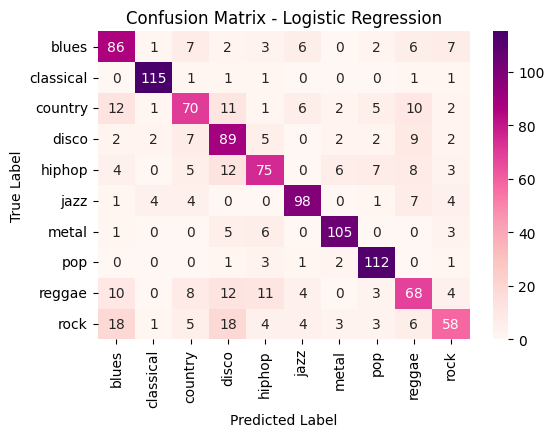

In [13]:
# Logistic Regression - Classification Report and Confusion Matrix

# Classification Report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_ml, y_pred_logreg, target_names=label_encoder_ml.classes_))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test_ml, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Saving the Model

In [42]:
# Module 5.1: Save Logistic Regression Model

model_filename = "models/lr_model.joblib"  # Path to save the model
os.makedirs(os.path.dirname(model_filename), exist_ok=True)  # Create directory if it doesn't exist
joblib.dump(best_logreg, model_filename)

print(f"Logistic Regression model saved successfully at {model_filename}")

Logistic Regression model saved successfully at models/lr_model.joblib


### Model 2: Random Forest

#### GSCV

In [14]:
# Random Forest - Hyperparameter Tuning

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_rf.fit(X_train_ml, y_train_ml)

best_rf = grid_rf.best_estimator_
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


#### Training and Prediction

In [17]:
# Random Forest - Training and Prediction
best_rf.fit(X_train_ml, y_train_ml)
y_pred_rf = best_rf.predict(X_test_ml)

#### Evaluation

Classification Report for Random Forest:
              precision    recall  f1-score   support

       blues       0.99      1.00      1.00       120
   classical       0.99      1.00      1.00       120
     country       0.97      1.00      0.98       120
       disco       0.95      0.98      0.97       120
      hiphop       0.99      0.97      0.98       120
        jazz       1.00      0.97      0.98       119
       metal       0.97      0.99      0.98       120
         pop       1.00      0.97      0.98       120
      reggae       0.99      1.00      1.00       120
        rock       0.99      0.96      0.97       120

    accuracy                           0.98      1199
   macro avg       0.98      0.98      0.98      1199
weighted avg       0.98      0.98      0.98      1199



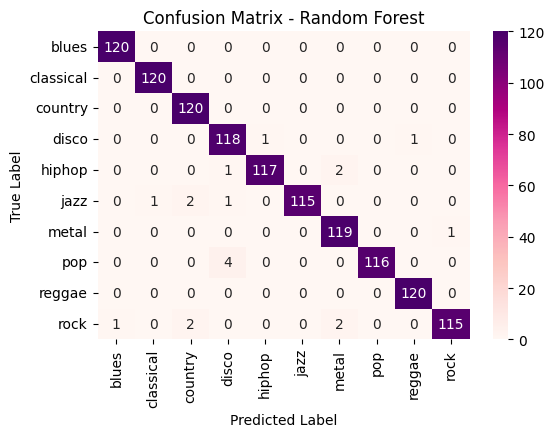

In [19]:
# Random Forest - Classification Report and Confusion Matrix

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test_ml, y_pred_rf, target_names=label_encoder_ml.classes_))

# Confusion Matrix
cm_rf = confusion_matrix(y_test_ml, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Saving the model

In [ ]:
# Module 5.2: Save Random Forest Model

model_filename = "models/rf_model.joblib"  # Path to save the model
os.makedirs(os.path.dirname(model_filename), exist_ok=True)  # Create directory if it doesn't exist
joblib.dump(best_rf, model_filename)

print(f"Random Forest model saved successfully at {model_filename}")

Random Forest model saved successfully at models/rf_model.joblib


#### Saving the model

### Model 3: XGBoost

#### GSCV

In [21]:
# XGBoost - Hyperparameter Tuning

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_xgb.fit(X_train_ml, y_train_ml)

best_xgb = grid_xgb.best_estimator_
print(f"Best parameters for XGBoost: {grid_xgb.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


#### Training and Prediction

In [22]:
# XGBoost - Training and Prediction
best_xgb.fit(X_train_ml, y_train_ml)
y_pred_xgb = best_xgb.predict(X_test_ml)

#### Evaluation

Classification Report for XGBoost:
              precision    recall  f1-score   support

       blues       0.98      0.98      0.98       120
   classical       1.00      0.99      1.00       120
     country       0.97      0.99      0.98       120
       disco       0.99      0.99      0.99       120
      hiphop       1.00      0.97      0.99       120
        jazz       0.98      0.99      0.99       119
       metal       0.98      0.98      0.98       120
         pop       1.00      0.99      1.00       120
      reggae       0.98      1.00      0.99       120
        rock       0.97      0.96      0.97       120

    accuracy                           0.99      1199
   macro avg       0.99      0.99      0.99      1199
weighted avg       0.99      0.99      0.99      1199



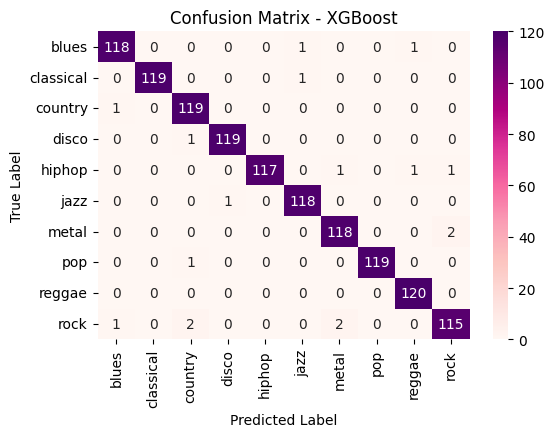

In [24]:
# XGBoost - Classification Report and Confusion Matrix
# Classification Report
print("Classification Report for XGBoost:")
print(classification_report(y_test_ml, y_pred_xgb, target_names=label_encoder_ml.classes_))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test_ml, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()

#### Saving the model

In [26]:
# Module 5.3: Save XGBoost Model

model_filename = "models/xgb_model.joblib"  # Path to save the model
os.makedirs(os.path.dirname(model_filename), exist_ok=True)  # Create directory if it doesn't exist
joblib.dump(best_xgb, model_filename)

print(f"XGBoost model saved successfully at {model_filename}")

XGBoost model saved successfully at models/xgb_model.joblib


### Model 4: SVM

#### GSCV

In [27]:
# SVM - Hyperparameter Tuning

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_svm.fit(X_train_ml, y_train_ml)

best_svm = grid_svm.best_estimator_
print(f"Best parameters for SVM: {grid_svm.best_params_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


#### Training and Prediction

In [28]:
# SVM - Training and Prediction
best_svm.fit(X_train_ml, y_train_ml)
y_pred_svm = best_svm.predict(X_test_ml)

#### Evaluation

Classification Report for SVM:
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       120
   classical       1.00      1.00      1.00       120
     country       1.00      1.00      1.00       120
       disco       0.96      1.00      0.98       120
      hiphop       1.00      0.99      1.00       120
        jazz       1.00      0.99      1.00       119
       metal       0.99      0.99      0.99       120
         pop       1.00      0.96      0.98       120
      reggae       1.00      1.00      1.00       120
        rock       0.98      1.00      0.99       120

    accuracy                           0.99      1199
   macro avg       0.99      0.99      0.99      1199
weighted avg       0.99      0.99      0.99      1199



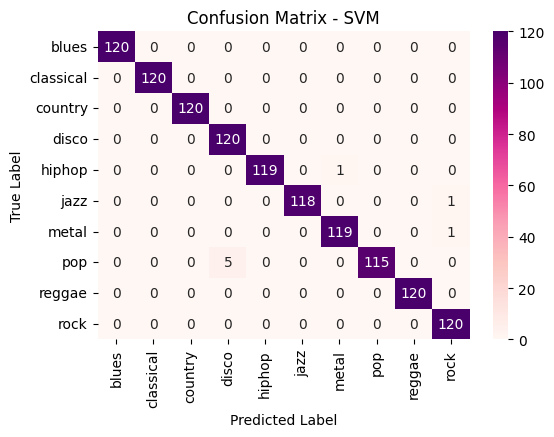

In [29]:
# SVM - Classification Report and Confusion Matrix

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test_ml, y_pred_svm, target_names=label_encoder_ml.classes_))

# Confusion Matrix
cm_svm = confusion_matrix(y_test_ml, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - SVM')
plt.show()

#### Save the Model

In [30]:
# Module 5.4: Save SVM Model

model_filename = "models/svm_model.joblib"  # Path to save the model
os.makedirs(os.path.dirname(model_filename), exist_ok=True)  # Create directory if it doesn't exist
joblib.dump(best_svm, model_filename)

print(f"SVM model saved successfully at {model_filename}")

SVM model saved successfully at models/svm_model.joblib


## MODULE 6: DL Model Training and Evaluation

### Model 1: MLP

#### Load Handcrafted Features for MLP

The MLP will be trained on the handcrafted features extrcated into the CSV file. So it needs to be loaded

In [43]:
# Module 6.1.1: Load Handcrafted Features

# Load augmented features from CSV
df = pd.read_csv("features/with_aug/augmented_features.csv")
X = df.drop("label", axis=1).values  # Features
y = df["label"].values  # Labels

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train/test
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train samples: {X_train_mlp.shape[0]}")
print(f"Test samples: {X_test_mlp.shape[0]}")

Train samples: 4795
Test samples: 1199


#### Define the MLP Architecture

In [44]:
# Module 6.1.2: Define MLP Architecture

def build_mlp_model(input_shape):
    """
    Build and compile an MLP model for classification.
    
    Args:
        input_shape (int): Flattened input size (e.g., number of features).
        
    Returns:
        model: Compiled MLP model.
    """
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 genres
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Input shape: Number of features
input_shape_mlp = X_train_mlp.shape[1]  # e.g., 65 features
mlp_model = build_mlp_model(input_shape_mlp)

# Print model summary
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,306 (778.54 KB)

 Trainable params: 199,306 (778.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the MLP Model

In [45]:
# Module 6.1.3: Train MLP Model

# Train the model
history_mlp = mlp_model.fit(
    X_train_mlp, y_train_mlp,
    validation_data=(X_test_mlp, y_test_mlp),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1229 - loss: 8.7999 - val_accuracy: 0.3403 - val_loss: 2.0254
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2270 - loss: 2.2765 - val_accuracy: 0.4053 - val_loss: 1.8720
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2699 - loss: 2.0522 - val_accuracy: 0.3978 - val_loss: 1.7441
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3300 - loss: 1.8687 - val_accuracy: 0.4245 - val_loss: 1.6845
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3556 - loss: 1.7936 - val_accuracy: 0.4887 - val_loss: 1.5895
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4010 - loss: 1.6848 - val_accuracy: 0.5346 - val_loss: 1.5005
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4235 - loss: 1.6210 - val_accuracy: 0.5379 - val_loss: 1.4064
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4594 - loss: 1.5289 - val_accuracy: 0.

#### Evaluate the MLP Model

In [46]:
# eval2

# Module 6.1.4: Evaluate MLP Model

# Evaluate on test data
test_loss_mlp, test_accuracy_mlp = mlp_model.evaluate(X_test_mlp, y_test_mlp)
print(f"Test Accuracy (MLP): {test_accuracy_mlp * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.2629 
Test Accuracy (MLP): 91.99%


In [39]:
# Module 6.1.4: Evaluate MLP Model

# Evaluate on test data
test_loss_mlp, test_accuracy_mlp = mlp_model.evaluate(X_test_mlp, y_test_mlp)
print(f"Test Accuracy (MLP): {test_accuracy_mlp * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.2827
Test Accuracy (MLP): 90.99%


#### Generate Classification Report and Confusion Matrix

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report for MLP:
              precision    recall  f1-score   support

       blues       0.95      0.95      0.95       120
   classical       0.95      0.99      0.97       120
     country       0.83      0.92      0.87       120
       disco       0.81      0.93      0.87       120
      hiphop       0.97      0.88      0.92       120
        jazz       0.97      0.93      0.95       119
       metal       0.96      0.91      0.93       120
         pop       0.97      0.94      0.96       120
      reggae       0.93      0.95      0.94       120
        rock       0.88      0.80      0.84       120

    accuracy                           0.92      1199
   macro avg       0.92      0.92      0.92      1199
weighted avg       0.92      0.92      0.92      1199



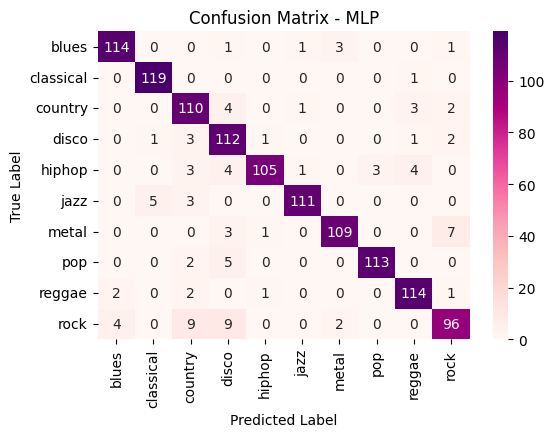

In [47]:
#report2

# Module 6.1.5: Classification Report and Confusion Matrix

# Predictions
y_pred_mlp_probs = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_mlp_probs, axis=1)

# Classification Report
print("Classification Report for MLP:")
print(classification_report(y_test_mlp, y_pred_mlp, target_names=label_encoder.classes_))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - MLP')
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report for MLP:
              precision    recall  f1-score   support

       blues       0.95      0.96      0.95       120
   classical       0.94      0.99      0.96       120
     country       0.94      0.87      0.90       120
       disco       0.86      0.83      0.85       120
      hiphop       0.87      0.94      0.90       120
        jazz       0.96      0.90      0.93       119
       metal       0.89      0.91      0.90       120
         pop       0.98      0.94      0.96       120
      reggae       0.89      0.94      0.91       120
        rock       0.82      0.82      0.82       120

    accuracy                           0.91      1199
   macro avg       0.91      0.91      0.91      1199
weighted avg       0.91      0.91      0.91      1199



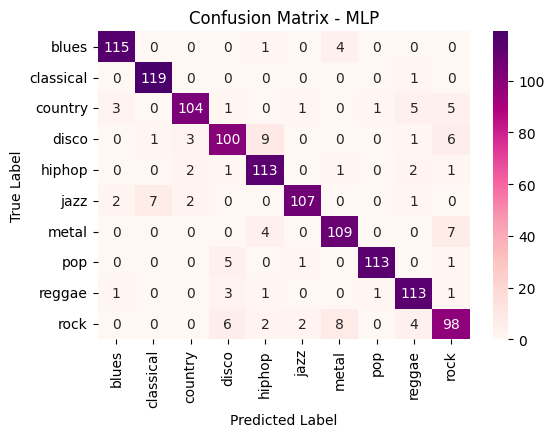

In [40]:
# Module 6.1.5: Classification Report and Confusion Matrix

# Predictions
y_pred_mlp_probs = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_mlp_probs, axis=1)

# Classification Report
print("Classification Report for MLP:")
print(classification_report(y_test_mlp, y_pred_mlp, target_names=label_encoder.classes_))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - MLP')
plt.show()

#### Save the Model

In [49]:
# Module 6.1.6 Save MLP Model

model_filename = "models/mlp_model.h5"  # Path to save the model
os.makedirs(os.path.dirname(model_filename), exist_ok=True)  # Create directory if it doesn't exist
mlp_model.save(model_filename)

print(f"MLP model saved successfully at {model_filename}")

MLP model saved successfully at models/mlp_model.h5


### Model 2: CNN

#### Define the CNN Architecture

In [ ]:
# Module 6.1: Define CNN Architecture

def build_cnn_model(input_shape):
    """
    Build and compile a CNN model for spectrogram classification.
    
    Args:
    input_shape (tuple): Shape of input spectrograms (height, width, channels).
        
    Returns:
    model: Compiled CNN model.
    """
    model = Sequential([
        # Conv Block 1
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Conv Block 2
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Conv Block 3
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Conv Block 4
        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Global Average Pooling
        GlobalAveragePooling2D(),
        
        # Dense Layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 genres
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

# Input shape: (128, 1293, 1)
input_shape_cnn = (128, 1293, 1)
cnn_model = build_cnn_model(input_shape_cnn)

# Print model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 1291, 64)  │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 1291, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 643, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 643, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 321, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 319, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 319, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 159, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 157, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 157, 512)   │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 78, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,950,218 (7.44 MB)

 Trainable params: 1,948,298 (7.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

#### Train the CNN Model

In [ ]:
# Module 6.2.2: Train CNN Model

# Train the model
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

#### Evaluate the CNN Model

In [21]:
# Module 6.2.3: Evaluate CNN Model

# Evaluate on test data
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {test_accuracy_cnn * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.5247 - loss: 1.3397
Test Accuracy (CNN): 55.71%


In [ ]:
# 6.2.3

#### Generate Classification Report and Confusion Matrix

In [ ]:
# 6.2.4

## MODULE 7: Building An Ensemble

### SUB-MODULE 7.1: Stacking Ensemble

#### Load Pre-Trained Models

In [13]:
# Define the path to the saved models
model_dir = "D:/COMPUTER SCIENCE/PYTHON/MACHINE LEARNING LAB/MINI PROJECT/GTZAN/models"

# Load traditional ML models (LR, RF, XGB, SVM)
lr_model = joblib.load(os.path.join(model_dir, "lr_model.joblib"))
rf_model = joblib.load(os.path.join(model_dir, "rf_model.joblib"))
xgb_model = joblib.load(os.path.join(model_dir, "xgb_model.joblib"))
svm_model = joblib.load(os.path.join(model_dir, "svm_model.joblib"))

# Load deep learning models (MLP)
mlp_model = load_model(os.path.join(model_dir, "mlp_model.h5"))

### Generate Base Model Predictions

#### Debug Predictions

This function is necessary as each model gives predictions in different formats. Some may prduce it as one hot encoded while some may produce as integer label encoded. While all ML models were producing 2 dimensional vector outputs, the MLP was producing  3 dimensional outputs. This function helped handle the dimensionality issue.

In [73]:
def debug_predictions(models, X):
    """
    Debug the predictions from each model to ensure consistency.
    
    Args:
        models (list): List of pre-trained models.
        X (np.array): Input data (features).
    """
    for i, model in enumerate(models):
        if hasattr(model, 'predict_proba'):  # Models with `predict_proba`
            pred = model.predict_proba(X)
        elif hasattr(model, 'predict'):  # Models with only `predict`
            pred = model.predict(X)
            if not np.issubdtype(pred.dtype, np.integer):  # Ensure integer class labels
                pred = pred.astype(int)
            pred = np.eye(len(np.unique(pred)))[pred]  # Convert to one-hot encoding
        elif callable(getattr(model, 'predict', None)):  # Keras models (e.g., MLP)
            pred = model.predict(X)
        
        print(f"Model {i} prediction shape: {pred.shape}, type: {type(pred)}")

# Debug predictions
debug_predictions([lr_model, rf_model, xgb_model, svm_model, mlp_model], X_train_ml)

Model 0 prediction shape: (4795, 10), type: <class 'numpy.ndarray'>
Model 1 prediction shape: (4795, 10), type: <class 'numpy.ndarray'>
Model 2 prediction shape: (4795, 10), type: <class 'numpy.ndarray'>
Model 3 prediction shape: (4795, 10), type: <class 'numpy.ndarray'>
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
Model 4 prediction shape: (4795, 10, 2), type: <class 'numpy.ndarray'>


#### Helper Function to Generate Predictions

This fuction will be used to generate predictions on which the meta model will then be trained.

In [86]:
def get_base_predictions(models, X):
    """
    Generate predictions from a list of base models.
    
    Args:
        models (list): List of pre-trained models.
        X (np.array): Input data (features).
        
    Returns:
        np.array: Stacked predictions from all base models.
    """
    predictions = []
    for i, model in enumerate(models):
        if model == mlp_model:  # Explicitly handle the MLP model
            pred = model.predict(X)
            print(f"Before reshaping - Model {i} prediction shape: {pred.shape}")
            if len(pred.shape) > 2:  # Flatten extra dimensions if needed
                pred = pred.reshape(pred.shape[0], -1)
            # Ensure MLP predictions have the same number of features as other models
            pred = pred[:, :10]  # Keep only the first 10 features (num_classes)
            print(f"After reshaping - Model {i} prediction shape: {pred.shape}")
        elif hasattr(model, 'predict_proba'):  # Models with `predict_proba`
            pred = model.predict_proba(X)
        elif hasattr(model, 'predict'):  # Models with only `predict`
            pred = model.predict(X)
            if not np.issubdtype(pred.dtype, np.integer):  # Ensure integer class labels
                pred = pred.astype(int)
            pred = np.eye(len(np.unique(pred)))[pred]  # Convert to one-hot encoding
        else:
            raise ValueError(f"Unsupported model type: {type(model)}")
        
        # Ensure predictions are 2D arrays
        if len(pred.shape) == 1:
            pred = pred.reshape(-1, 1)  # Reshape to (num_samples, 1) if necessary
        
        predictions.append(pred)
    
    # Stack predictions horizontally
    return np.hstack(predictions)

#### Generate Predictions

In [87]:
# List of base models
base_models = [lr_model, rf_model, xgb_model, svm_model, mlp_model]

# Generate predictions for training and test sets
X_train_meta = get_base_predictions(base_models, X_train_ml)
X_test_meta = get_base_predictions(base_models, X_test_ml)

print(f"Meta-feature shape (train): {X_train_meta.shape}")
print(f"Meta-feature shape (test): {X_test_meta.shape}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
Before reshaping - Model 4 prediction shape: (4795, 10)
After reshaping - Model 4 prediction shape: (4795, 10)
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Before reshaping - Model 4 prediction shape: (1199, 10)
After reshaping - Model 4 prediction shape: (1199, 10)
Meta-feature shape (train): (4795, 50)
Meta-feature shape (test): (1199, 50)


#### Train the Meta Model

In [88]:
# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(X_train_meta, y_train_ml)

# Evaluate the meta-model on the test set
y_pred_meta = meta_model.predict(X_test_meta)
accuracy_meta = accuracy_score(y_test_ml, y_pred_meta)
print(f"Stacking Ensemble Accuracy: {accuracy_meta * 100:.2f}%")

Stacking Ensemble Accuracy: 99.50%


#### Model Evaluation

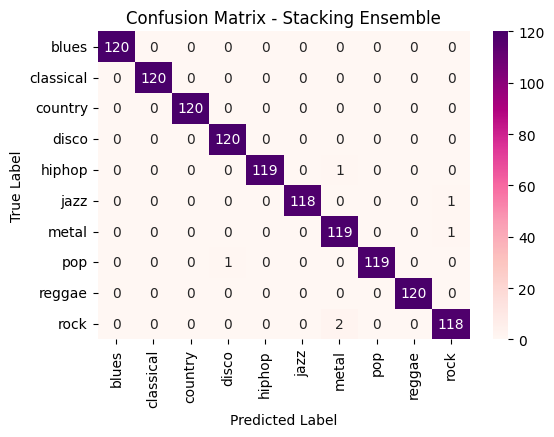

In [92]:
# Compute the confusion matrix
cm_meta = confusion_matrix(y_test_ml, y_pred_meta)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_meta, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Stacking Ensemble')
plt.show()

#### Saving the Meta Model

In [93]:
# Define the path to the models directory
models_dir = r"D:\COMPUTER SCIENCE\PYTHON\MACHINE LEARNING LAB\MINI PROJECT\GTZAN\models"

# Create the directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Save the stacking meta-model
stacking_meta_model_path = os.path.join(models_dir, "stacking_meta_model.joblib")
joblib.dump(meta_model, stacking_meta_model_path)

print("Stacking meta-model saved successfully!")

Stacking meta-model saved successfully!


In [ ]:
# X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
#     X_ml, y_ml_encoded, test_size=0.2, stratify=y_ml_encoded, random_state=42
# )

### SUB-MODULE 7.2: Voting Ensemble

#### Define the Voting Ensemble

#### Train the Voting Ensemble

Wrapping the model

voting ensemble

Train and Evaluate

===============================================================================================

In [135]:
def get_predictions(models, X):
    """
    Generate predictions from a list of models.
    
    Args:
        models (list): List of pre-trained models (excluding MLP).
        X (np.array): Input data (features).
        
    Returns:
        np.array: Array of predictions from all models (shape: [num_models, num_samples]).
    """
    all_predictions = []
    for i, model in enumerate(models):
        if hasattr(model, 'predict_proba'):  # Models with `predict_proba`
            pred = model.predict(X)
        elif hasattr(model, 'predict'):  # Models with only `predict`
            pred = model.predict(X)
            if not np.issubdtype(pred.dtype, np.integer):  # Ensure integer class labels
                pred = pred.astype(int)
        
        # Ensure predictions are 1D arrays of integers
        if len(pred.shape) > 1:
            raise ValueError(f"Unexpected prediction shape from model {i}: {pred.shape}. Ensure all predictions are 1D arrays.")
        
        all_predictions.append(pred)
    
    return np.array(all_predictions)

Combine the predictions from the other models with the preprocessed MLP predictions.

In [136]:
# Step 1: Define the list of models (excluding MLP)
base_models = [lr_model, rf_model, xgb_model, svm_model]

# Step 2: Generate predictions for the other models
train_predictions = get_predictions(base_models, X_train_ml)
test_predictions = get_predictions(base_models, X_test_ml)

# Step 3: Add the preprocessed MLP predictions
train_predictions = np.vstack([train_predictions, mlp_train_labels.reshape(1, -1)])
test_predictions = np.vstack([test_predictions, mlp_test_labels.reshape(1, -1)])

print(f"Train predictions shape: {train_predictions.shape}")
print(f"Test predictions shape: {test_predictions.shape}")

Train predictions shape: (5, 4795)
Test predictions shape: (5, 1199)


In [137]:
def hard_voting(predictions):
    """
    Perform hard voting to combine predictions from multiple models.
    
    Args:
        predictions (np.array): Array of predictions from all models (shape: [num_models, num_samples]).
        
    Returns:
        np.array: Final predictions based on majority voting.
    """
    from scipy.stats import mode
    final_predictions, _ = mode(predictions, axis=0)
    return final_predictions.ravel()  # Flatten the result

# Perform hard voting
y_train_pred = hard_voting(train_predictions)
y_test_pred = hard_voting(test_predictions)

Training Accuracy (Hard Voting): 99.98%
Test Accuracy (Hard Voting): 98.75%


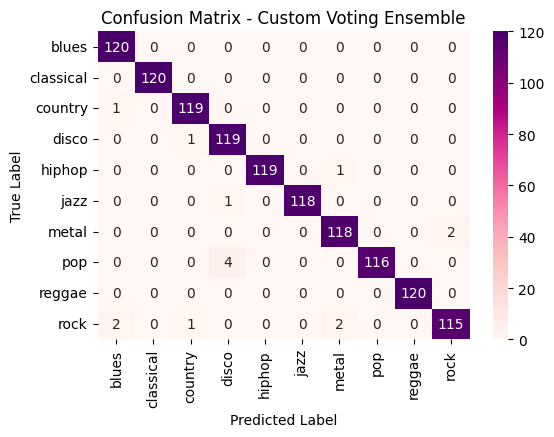

In [140]:
# Evaluate the ensemble
accuracy_train = accuracy_score(y_train_ml, y_train_pred)
accuracy_test = accuracy_score(y_test_ml, y_test_pred)
print(f"Training Accuracy (Hard Voting): {accuracy_train * 100:.2f}%")
print(f"Test Accuracy (Hard Voting): {accuracy_test * 100:.2f}%")

# Generate a confusion matrix
cm_voting = confusion_matrix(y_test_ml, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='RdPu',
            xticklabels=label_encoder_ml.classes_, yticklabels=label_encoder_ml.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Custom Voting Ensemble')
plt.show()

In [141]:
joblib.dump(label_encoder_ml, os.path.join(models_dir, "label_encoder_ml.joblib"))

['D:\\COMPUTER SCIENCE\\PYTHON\\MACHINE LEARNING LAB\\MINI PROJECT\\GTZAN\\models\\label_encoder_ml.joblib']

## MORE TRAINING LOGS 

In [ ]:
# Loading dataset from C:\Users\Kewal\Desktop\GTZAN\Data\genres_original...
# Total files: 999
# Dataset loaded in 0.01 seconds
# Extracting features...
# Total features after augmentation: 12987
# Feature extraction completed in 12297.80 seconds
# Train samples: 10389, Test samples: 2598
# Training models...
# Training SVM...
# SVM - Accuracy: 0.9584, Training time: 1175.79 seconds
# Training Random Forest...
# Random Forest - Accuracy: 0.9607, Training time: 33.31 seconds
# Training XGBoost...
# XGBoost - Accuracy: 0.9719, Training time: 31.25 seconds
# Training MLP...
# MLP - Accuracy: 0.9473, Training time: 22.56 seconds
# Training Gradient Boosting...
# Gradient Boosting - Accuracy: 0.9681, Training time: 2665.00 seconds
# Training Voting Ensemble...
# Training Stacking Ensemble...
# Voting Ensemble Accuracy: 0.9750
# Stacking Ensemble Accuracy: 0.9731
# Best Ensemble: Voting Ensemble with accuracy: 0.9750
# Training specialized real-time model...
# Real-time Model Accuracy: 0.9684
# All models and preprocessing objects saved successfully!

# Classification Report:
#               precision    recall  f1-score   support

#        Blues       0.98      0.99      0.99       260
#    Classical       0.98      1.00      0.99       260
#      Country       0.97      0.98      0.98       260
#        Disco       0.95      0.96      0.95       260
#       HipHop       0.99      0.98      0.98       260
#         Jazz       0.98      0.99      0.99       258
#        Metal       0.98      0.98      0.98       260
#          Pop       0.99      0.97      0.98       260
#       Reggae       0.98      0.96      0.97       260
#         Rock       0.94      0.94      0.94       260

#     accuracy                           0.97      2598
#    macro avg       0.98      0.97      0.97      2598
# weighted avg       0.98      0.97      0.97      2598

# Total execution time: 51914.77 seconds